In [1]:
import strongholds
import strongholds.graphing as mplt

import numpy as np

from matplotlib import pyplot as plt, gridspec
from matplotlib.widgets import Button, Slider

fixed_rng = np.random.default_rng(0)

To predict where the nearest stronghold to the player will be, we can simply generate many different worlds, find the closest stronghold to each one, and plot a histogram of the results.

In [2]:
stronghold_sets = strongholds.generation_heatmap(1*10**4, rng=fixed_rng, concatenate=False)

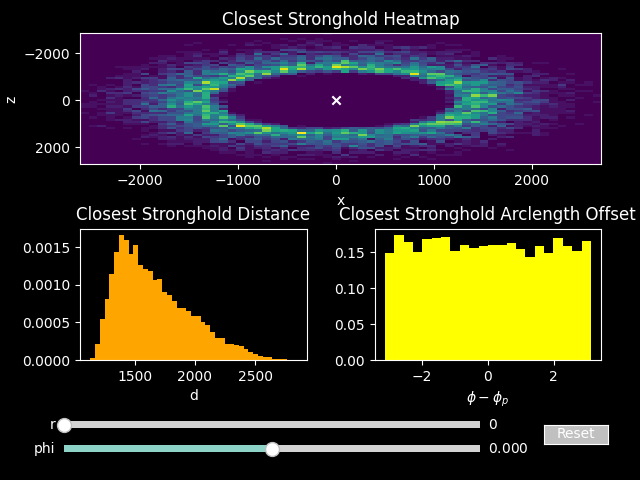

In [3]:
%matplotlib widget

# 2x2 grid
gs = gridspec.GridSpec(2, 2)

fig = plt.figure()
ax = []
ax.append(fig.add_subplot(gs[0, :]))
ax.append(fig.add_subplot(gs[1, 0]))
ax.append(fig.add_subplot(gs[1, 1]))

fig.tight_layout(pad=2, h_pad=3.5)
fig.subplots_adjust(left=0.125, bottom=0.25)

#fig, ax = plt.subplots(3, 1, figsize=(6, 9))

ax[0].set_title("Closest Stronghold Heatmap")
ax[0].set_xlabel("x")
ax[0].set_ylabel("z")

ax[1].set_title("Closest Stronghold Distance")
ax[1].set_xlabel("d")

ax[2].set_title("Closest Stronghold Arclength Offset")
ax[2].set_xlabel("$\\phi - \\phi_p$")

player = strongholds.rectpoint(0, 0)
closest_strongholds = strongholds.closest_stronghold(player, stronghold_sets)

distances = strongholds.radius(closest_strongholds - player)
angles = strongholds.angle(closest_strongholds) - strongholds.angle(player)

# xz plot
_, _, _, hist2d = ax[0].hist2d(closest_strongholds.real,
                         closest_strongholds.imag,
                         bins=60, density=True)
player_point = ax[0].scatter(player.real, player.imag, marker="x", zorder=1000, color="white")

# radii and angles plot
_, _, hist_d = ax[1].hist(distances, bins="auto", density=True, color="orange")
_, _, hist_theta = ax[2].hist(angles, bins="auto", density=True, color="yellow")

# add sliders
ax_r = fig.add_axes([0.1, 0.1, 0.65, 0.03])
ax_phi = fig.add_axes([0.1, 0.05, 0.65, 0.03])
r_slider = Slider(ax=ax_r, label="r", valmin=0, valmax=25000, valinit=0)
phi_slider = Slider(ax=ax_phi, label="phi", valmin=-np.pi, valmax=np.pi, valinit=0)

def update(val=None):
    global hist2d, hist_d, hist_theta
    # update player location and resulting outputs
    player = strongholds.polarpoint(r_slider.val, phi_slider.val)
    closest_strongholds = strongholds.closest_stronghold(player, stronghold_sets)

    distances = strongholds.radius(closest_strongholds - player)
    angles = strongholds.angle(closest_strongholds) - strongholds.angle(player)

    # update xz plot
    hist2d.remove()
    _, _, _, hist2d = ax[0].hist2d(closest_strongholds.real,
                         closest_strongholds.imag,
                         bins=60, density=True)
    player_point.set_offsets(strongholds.math.to_xz(player))

    # update radii and angles plots
    hist_d.remove()
    hist_theta.remove()
    
    _, _, hist_d = ax[1].hist(distances, bins="auto", density=True, color="orange")
    _, _, hist_theta = ax[2].hist(angles, bins="auto", density=True, color="yellow")

    # update view
    for ax_ in ax:
        ax_.relim()
        ax_.autoscale_view()

    mplt.flip_zaxis(ax[0])

r_slider.on_changed(update)
phi_slider.on_changed(update)

resetax = fig.add_axes((0.85, 0.075, 0.1, 0.04))
button = Button(resetax, 'Reset', color="silver", hovercolor="blue")

def resetSlider(event) -> None:
    r_slider.reset()
    phi_slider.reset()

button.on_clicked(resetSlider)

mplt.flip_zaxis(ax[0])

As expected, stronghold generation is approximately symmetric in $\phi$, so we can perform future analyses in terms of $r$ only. From there, we find that the closest stronghold is in a small segment of the closest ring that tapers off as the angle deviates, with the contribution from the second closest ring varying with how far it is relative to the first.

Let's analyze the probability that you'll find the closest stronghold in a given ring:

In [4]:
c = np.vectorize(strongholds.closest_stronghold, signature="(),(n,128)->(n)")
r = np.linspace(0, 30000, 2000)

s = c(r, stronghold_sets)
i = strongholds.chunk_math.closest_ring(r)
j = strongholds.chunk_math.closest_ring(s)

mj, dj = j.mean(axis=-1), j.std(axis=-1)

bin_j = np.apply_along_axis(lambda a: np.histogram(a, bins=8, range=(0, 8), density=True)[0], 1, j)

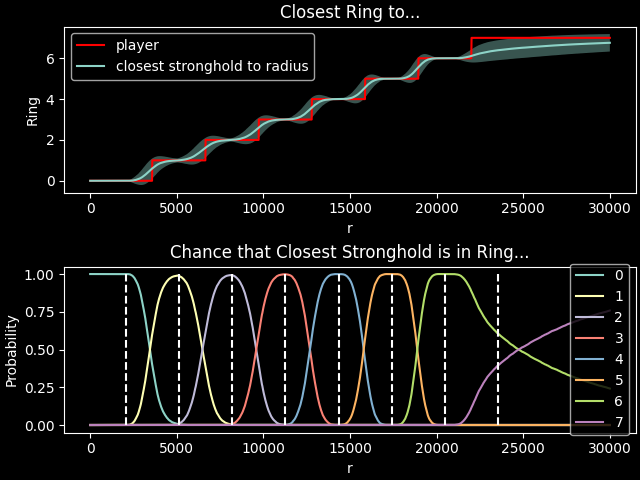

In [5]:
fig2, ax2 = plt.subplots(2, 1, constrained_layout=True)

ax2[0].set_title("Closest Ring to...")
ax2[0].set_xlabel("r")
ax2[0].set_ylabel("Ring")

ax2[1].set_title("Chance that Closest Stronghold is in Ring...")
ax2[1].set_xlabel("r")
ax2[1].set_ylabel("Probability")

p1, = ax2[0].plot(r, i, color="red", label="player")

p2, = ax2[0].plot(r, mj, label="closest stronghold to radius")
dp2 = ax2[0].fill_between(r, mj - dj, mj + dj, alpha=0.4)

for k in range(8):
    _ = ax2[1].plot(r, bin_j[:, k], label=str(k))

_ = ax2[1].vlines(strongholds.chunk_math.ring_centers, 0, 1, linestyles="dashed")

_ = ax2[0].legend()
_ = ax2[1].legend(loc="center right")

Breaking this down, we find that for an intermediate ring $k$, the closer you are radially to the middle of the ring $\bar{r}_k$, the more likely it is that the closest stronghold will be within the same ring. This is also guaranteed for $r \leq \bar{r}_0$ (as that places you on the interior of the 0th ring).

The deviation in end behavior for $k \in \{6, 7\}$ occurs because the rings terminate after $k = 7$; if there were more rings, they would follow a similar generation pattern.